In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M53_01_02.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_04.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_04_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_01_09.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_03_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_02_10.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_06.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_01_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_10.jpg
/kaggle/input/monkeypox-s

In [3]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import cv2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_and_preprocess_images(folder_path, subfolders, image_size=(224, 224)):
    
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}
    
    images = []
    labels = []
    
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                
                img_resized = cv2.resize(img, image_size)
                images.append(img_resized)
                labels.append(label_map[subfolder])
    
    images = np.array(images)
    labels = np.array(labels)
    
    images = images.astype('float32') / 255.0
    
    return images, labels

In [5]:
folder_path ="/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
subfolders = ['Monkeypox_augmented','Others_augmented']

In [6]:
images, labels = load_and_preprocess_images(folder_path, subfolders)

In [7]:
# One-hot encode the labels to match the model output
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=2) #used for encoding(string to binary(0 & 1))

In [8]:
# Split into training, temp(validation, and test sets)
x_train,x_temp,y_train,y_temp = train_test_split(
    images, labels_one_hot, test_size=0.3, random_state=42, stratify=labels
)
# Further split the temp set into validation and test sets
x_val,x_test,y_val,y_test  = train_test_split(
    x_temp,y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [9]:
print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")

Training set size: 2234
Validation set size: 479
Test set size: 479


In [10]:
base_model = VGG19(weights='imagenet', include_top=False,pooling = 'avg', input_shape=(224, 224, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Step 5: Create the model and add custom layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu')) # First dense layer
model.add(tf.keras.layers.Dropout(0.2))   # to avoid overfitting
model.add(Dense(2, activation='softmax')) # Output layer for binary classification(2classes)


In [16]:
# Step 6: Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Use categorical cross-entropy since we're one-hot encoding
              metrics=['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')])

In [17]:
history_vgg = model.fit(
    x_train,y_train,
    validation_data=(x_val,y_val),
    epochs=25,
    batch_size = 32
)

Epoch 1/25


I0000 00:00:1730697075.255698      99 service.cc:145] XLA service 0x7e91f4009190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730697075.255754      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730697096.545997      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 69s 625ms/step - accuracy: 0.5692 - loss: 0.7083 - precision: 0.5692 - recall: 0.5692 - val_accuracy: 0.6827 - val_loss: 0.5878 - val_precision: 0.6827 - val_recall: 0.6827
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.7132 - loss: 0.5721 - precision: 0.7132 - recall: 0.7132 - val_accuracy: 0.7453 - val_loss: 0.5513 - val_precision: 0.7453 - val_recall: 0.7453
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.7460 - loss: 0.5249 - precision: 0.7460 - recall: 0.7460 - val_accuracy: 0.8309 - val_loss: 0.4168 - val_precision: 0.8309 - val_recall: 0.8309
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.8128 - loss: 0.4232 - precision: 0.8128 - recall: 0.8128 - val_accuracy: 0.7578 - val_loss: 0.6016 - val_precision: 0.7578 - val_recall: 0.7578
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.8428 - loss: 0.3714 - precision: 0.8428 - recall: 0.8428 - val_accuracy: 0.8810 - val_loss: 0.3046 -

In [18]:
results = model.evaluate(x_test,y_test)
test_loss, test_accuracy, precision, recall = results

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1_score * 100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9568 - loss: 0.1364 - precision: 0.9568 - recall: 0.9568
Test Loss: 0.1422
Test Accuracy: 95.62%
Precision: 95.62%
Recall: 95.62%
F1 Score: 95.62%


In [19]:
model.save('monkeypox_fork_vgg19_model.h5')

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,655,240 (235.20 MB)

 Trainable params: 20,551,746 (78.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,103,494 (156.80 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


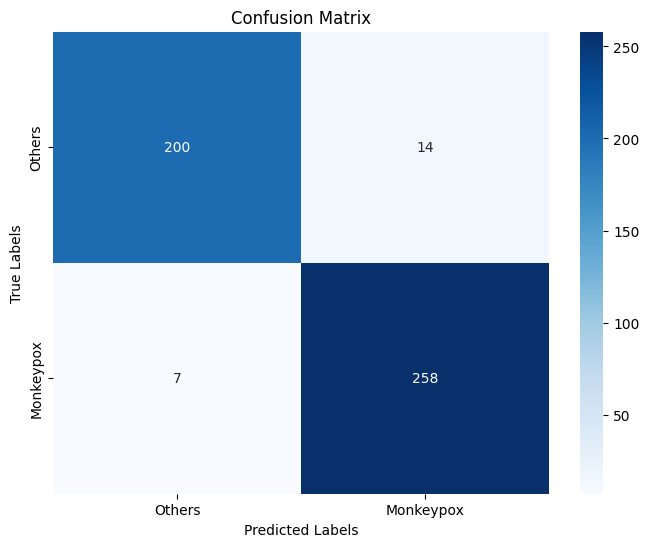

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions (ensure these are probabilities)
predictions = model.predict(x_test)

# Convert probabilities to binary predictions (0 or 1)
predictions = np.argmax(predictions, axis=1)  # Convert one-hot predictions to single class labels

# Convert one-hot encoded test_labels to single class labels
test_labels_single = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels_single, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Others', 'Monkeypox'], yticklabels=['Others', 'Monkeypox'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


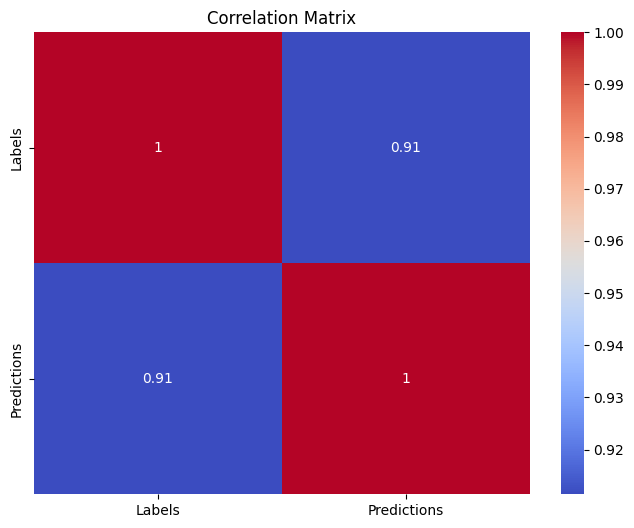

In [22]:
# Data for the correlation matrix, make sure both arrays have the same length
data = {
    'Labels': test_labels_single,        # Use test_labels_single (not the entire labels)
    'Predictions': predictions.flatten() # Use predictions from test set
}

# Create DataFrame
df = pd.DataFrame(data)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

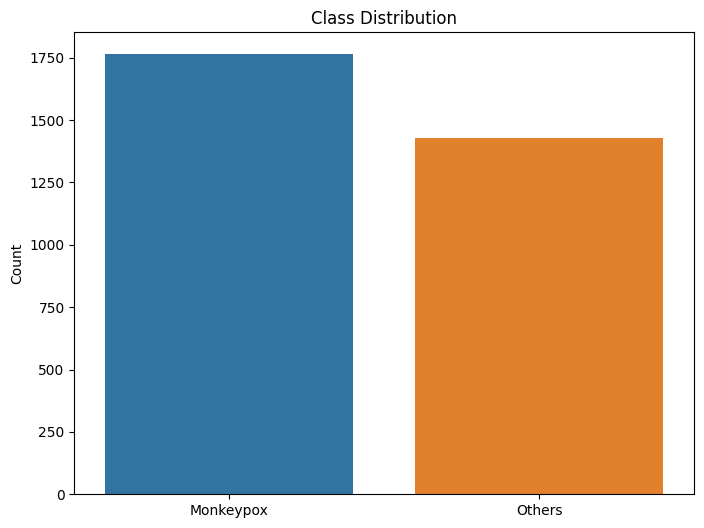

In [23]:
# Bar Plot for Class Distribution
class_names = ['Monkeypox', 'Others']
class_distribution = [np.sum(labels == 1), np.sum(labels == 0)]

plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_distribution)
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


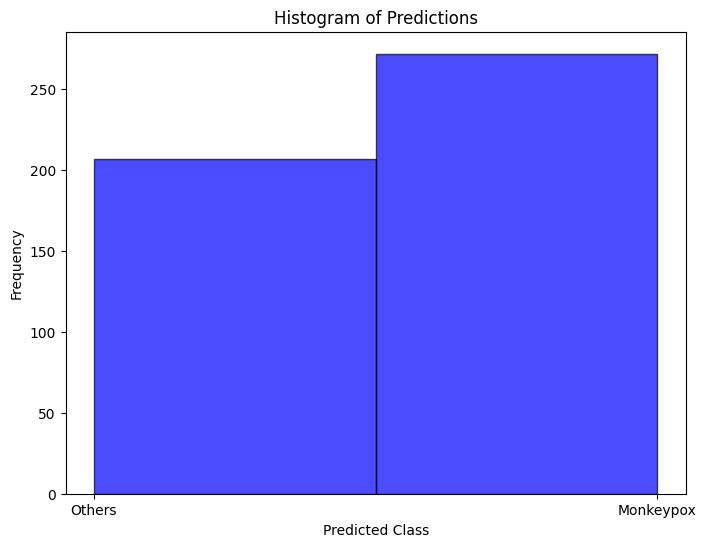

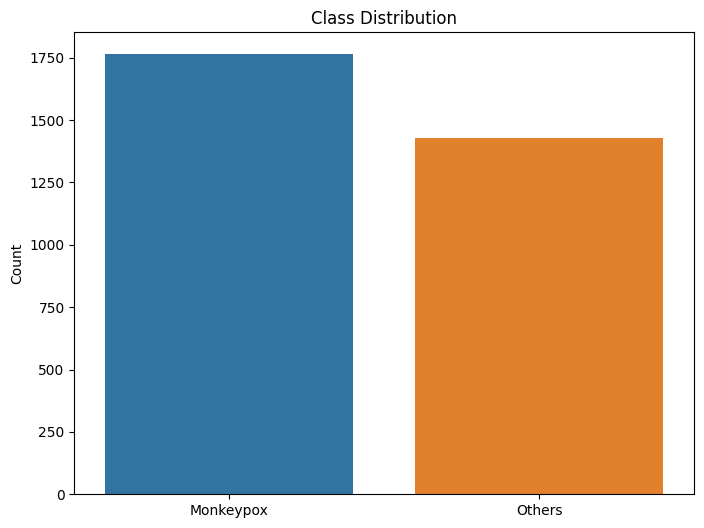

In [24]:
# Histogram of Model Predictions
plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=2, alpha=0.7, color='blue', edgecolor='black')
plt.xticks([0, 1], ['Others', 'Monkeypox'])
plt.xlabel('Predicted Class')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')# Bar Plot for Class Distribution
class_names = ['Monkeypox', 'Others']
class_distribution = [np.sum(labels == 1), np.sum(labels == 0)]

plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_distribution)
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

plt.show()


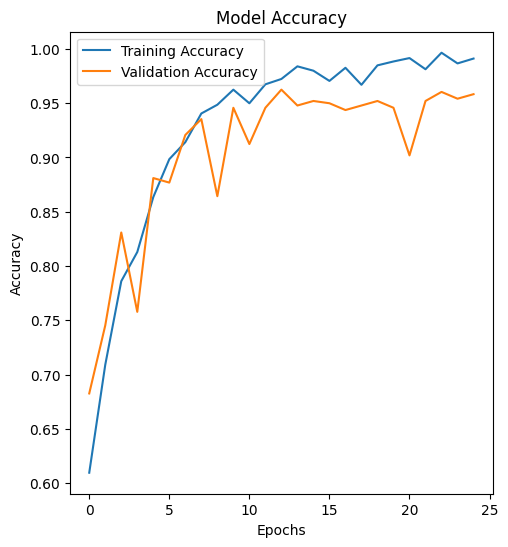

In [25]:
# Training History Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

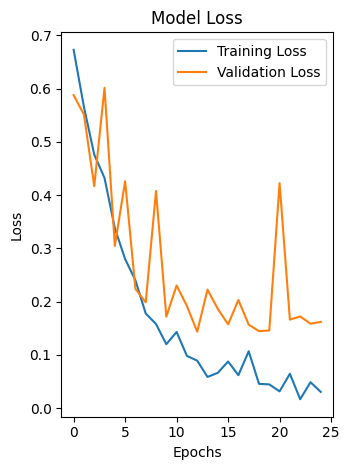

In [26]:
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()